<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-04-09 18:10:11--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.08s   

2019-04-09 18:10:12 (270 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following packages will be UPDATED:

    seaborn: 0.8.0-py35h15a2772_0 --> 0.9.0-py35_0 anaconda

seaborn-0.9.0- 100% |################################| Time: 0:00:00   9.46 MB/s


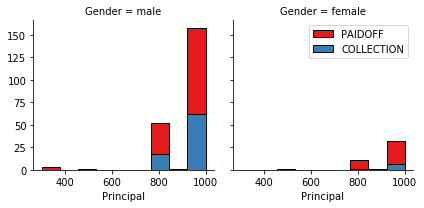

In [13]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

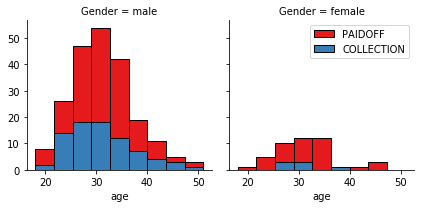

In [14]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

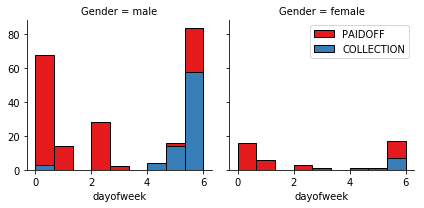

In [15]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [16]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [17]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [18]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [19]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [20]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [21]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [22]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [23]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [24]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
## import sklearn.metrics as metrics

In [27]:

seed=40
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.40, random_state=seed)

In [28]:
score=[]
for k in range(1,100):
    knn=KNeighborsClassifier(n_neighbors=k,weights='uniform')
    knn.fit(X_train,y_train)
    predKNN=knn.predict(X_test)
    accuracy=metrics.accuracy_score(predKNN,y_test)
    score.append(accuracy*100)
    print (k,': ',accuracy)

1 :  0.68345323741
2 :  0.611510791367
3 :  0.776978417266
4 :  0.769784172662
5 :  0.748201438849
6 :  0.712230215827
7 :  0.762589928058
8 :  0.741007194245
9 :  0.769784172662
10 :  0.776978417266
11 :  0.784172661871
12 :  0.769784172662
13 :  0.748201438849
14 :  0.762589928058
15 :  0.741007194245
16 :  0.741007194245
17 :  0.755395683453
18 :  0.726618705036
19 :  0.726618705036
20 :  0.73381294964
21 :  0.748201438849
22 :  0.73381294964
23 :  0.755395683453
24 :  0.755395683453
25 :  0.755395683453
26 :  0.769784172662
27 :  0.762589928058
28 :  0.762589928058
29 :  0.762589928058
30 :  0.762589928058
31 :  0.755395683453
32 :  0.755395683453
33 :  0.769784172662
34 :  0.769784172662
35 :  0.769784172662
36 :  0.776978417266
37 :  0.769784172662
38 :  0.769784172662
39 :  0.769784172662
40 :  0.769784172662
41 :  0.762589928058
42 :  0.762589928058
43 :  0.762589928058
44 :  0.762589928058
45 :  0.762589928058
46 :  0.762589928058
47 :  0.762589928058
48 :  0.762589928058
49 :

In [29]:
print(score.index(max(score))+1,' : ',round(max(score),2),'%')

11  :  78.42 %


Text(0,0.5,'Training Dataset Accuracy')

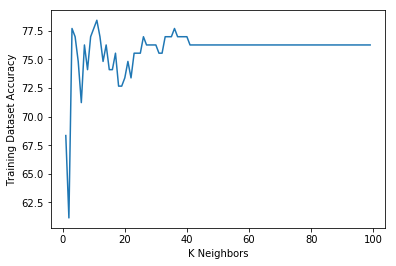

In [30]:
plt.plot(range(1,100),score)
plt.xlabel('K Neighbors')
plt.ylabel('Training Dataset Accuracy')

In [31]:

knn=KNeighborsClassifier(n_neighbors=41,weights='uniform')
knn.fit(X_train,y_train)
predKNN=knn.predict(X_test)
accuracy=metrics.accuracy_score(predKNN,y_test)
print("accuracy : ",round(accuracy,3)*100,'%')

accuracy :  76.3 %


In [41]:
#from sklearn.metrics import precision_accuracy

print(classification_report(y_test,predKNN))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_test,predKNN)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_test,predKNN,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y_train, knn.predict(X_train))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       0.00      0.00      0.00        33
    PAIDOFF       0.76      1.00      0.87       106

avg / total       0.58      0.76      0.66       139



Jaccard Similarity Score :  76.26 %


F1-SCORE :  [ 0.          0.86530612]


Train Accuracy:  74.3961352657 %


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Decision Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
dtree=DecisionTreeClassifier()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [44]:
parameter_grid = {'max_depth': [1, 2, 3, 4, 5,6,5,9,15,20],
                  'max_features': [1, 2, 3, 4,5,6,7,8],
                 'random_state':[0,15,20,35,50,80,100,150,180,200],
                 'criterion':['gini','entropy'],
                 }

grid_search = GridSearchCV(dtree, param_grid = parameter_grid,
                          cv =10)

grid_search.fit(X_train, y_train)

print ("Best_Score: {}".format(grid_search.best_score_))
print ("Best_params: {}".format(grid_search.best_params_))

Best_Score: 0.7536231884057971
Best_params: {'max_depth': 4, 'max_features': 2, 'criterion': 'entropy', 'random_state': 20}


In [45]:

dtree=DecisionTreeClassifier(max_depth=5,criterion='entropy',max_features=2,random_state=0)

In [46]:
dtree.fit(X_train,y_train)
pred_Dtree=dtree.predict(X_test)

In [47]:
print(classification_report(y_test,pred_Dtree))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_test,pred_Dtree)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_test,pred_Dtree,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y_train, dtree.predict(X_train))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       0.49      0.52      0.50        33
    PAIDOFF       0.85      0.83      0.84       106

avg / total       0.76      0.76      0.76       139



Jaccard Similarity Score :  75.54 %


F1-SCORE :  [ 0.5         0.83809524]


Train Accuracy:  77.2946859903 %


# Support Vector Machine

In [48]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [49]:
svm=SVC().fit(X_train,y_train)

In [50]:
pred_svm=svm.predict(X_test)

In [51]:
print(classification_report(y_test,pred_svm))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_test,pred_svm)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_test,pred_svm,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y_train, svm.predict(X_train))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       0.43      0.09      0.15        33
    PAIDOFF       0.77      0.96      0.86       106

avg / total       0.69      0.76      0.69       139



Jaccard Similarity Score :  75.54 %


F1-SCORE :  [ 0.15        0.85714286]


Train Accuracy:  76.8115942029 %


# Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
lgm=LogisticRegression()

In [54]:
lgm.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [56]:
pred_lgm=lgm.predict(X_test)

In [57]:
print(classification_report(y_test,pred_lgm))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_test,pred_lgm)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_test,pred_lgm,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y_train, lgm.predict(X_train))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       0.47      0.27      0.35        33
    PAIDOFF       0.80      0.91      0.85       106

avg / total       0.72      0.76      0.73       139



Jaccard Similarity Score :  75.54 %


F1-SCORE :  [ 0.34615385  0.84955752]


Train Accuracy:  76.3285024155 %


# Model Evaluation using Test set

In [58]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [59]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-04-09 18:34:00--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-04-09 18:34:00 (589 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [60]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [61]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [62]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6


In [63]:
test_df['weekend']=test_df['dayofweek'].apply(lambda x: 1 if (x>3) else 0)

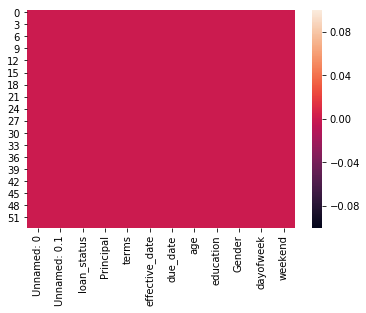

In [64]:
sns.heatmap(test_df.isnull())

In [65]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [66]:
dumm=pd.get_dummies(test_df['education'])
#dumm=dumm.drop('Master or Above',axis=1,inplace=True)
dumm=dumm[['Bechalor','High School or Below','college']]

In [67]:
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,dumm], axis=1)
#test_feature.drop(['Master or Above'], axis = 1,inplace=True)
test_feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [68]:
test_data= test_feature
test_data= preprocessing.StandardScaler().fit(test_data).transform(test_data)

In [69]:
y_t=test_df['loan_status']

In [ ]:
### Knn Algorithm 

In [70]:
knn=KNeighborsClassifier()
knn.fit(X,y)
predKNN_test=knn.predict(test_data)
accuracy=metrics.accuracy_score(predKNN_test,y_t)
print("accuracy : ",round(accuracy,3)*100,'%')

accuracy :  74.1 %


In [72]:
score=[]
for k in range(1,100):
    knn=KNeighborsClassifier(n_neighbors=k,weights='uniform')
    knn.fit(X,y)
    predKNN=knn.predict(test_data)
    accuracy=metrics.accuracy_score(predKNN,y_t)
    score.append(accuracy*100)
    print (k,': ',accuracy)

1 :  0.703703703704
2 :  0.574074074074
3 :  0.648148148148
4 :  0.62962962963
5 :  0.740740740741
6 :  0.685185185185
7 :  0.722222222222
8 :  0.703703703704
9 :  0.703703703704
10 :  0.685185185185
11 :  0.685185185185
12 :  0.666666666667
13 :  0.703703703704
14 :  0.703703703704
15 :  0.722222222222
16 :  0.703703703704
17 :  0.722222222222
18 :  0.703703703704
19 :  0.722222222222
20 :  0.740740740741
21 :  0.759259259259
22 :  0.759259259259
23 :  0.759259259259
24 :  0.722222222222
25 :  0.740740740741
26 :  0.777777777778
27 :  0.759259259259
28 :  0.777777777778
29 :  0.759259259259
30 :  0.777777777778
31 :  0.740740740741
32 :  0.796296296296
33 :  0.777777777778
34 :  0.796296296296
35 :  0.796296296296
36 :  0.777777777778
37 :  0.796296296296
38 :  0.796296296296
39 :  0.796296296296
40 :  0.796296296296
41 :  0.796296296296
42 :  0.796296296296
43 :  0.777777777778
44 :  0.796296296296
45 :  0.796296296296
46 :  0.796296296296
47 :  0.777777777778
48 :  0.777777777778
49

In [73]:
print(score.index(max(score))+1,' : ',round(max(score),2),'%')

32  :  79.63 %


In [74]:
knn=KNeighborsClassifier(n_neighbors=32)
knn.fit(X,y)
predKNN_test=knn.predict(test_data)
accuracy=metrics.accuracy_score(predKNN_test,y_t)
print("accuracy : ",round(accuracy,3)*100,'%')

accuracy :  79.6 %


In [75]:
print(classification_report(y_t,predKNN_test))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_t,predKNN_test)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_t,predKNN_test,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y,knn.predict(X))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       0.71      0.36      0.48        14
    PAIDOFF       0.81      0.95      0.87        40

avg / total       0.78      0.80      0.77        54



Jaccard Similarity Score :  79.63 %


F1-SCORE :  [ 0.47619048  0.87356322]


Train Accuracy:  74.8554913295 %


In [ ]:
### DT Algorithm

In [76]:
parameter_grid = {'max_depth': [1, 2, 3, 4, 5,6,5,9,15,20],
                  'max_features': [1, 2, 3, 4,5,6,7,8],
                 'random_state':[0,15,20,35,50,80,100,150,180,200],
                 'criterion':['gini','entropy'],
                 }

grid_search = GridSearchCV(dtree, param_grid = parameter_grid,
                          cv =10)

grid_search.fit(X, y)

print ("Best Score: {}".format(grid_search.best_score_))
print ("Best params: {}".format(grid_search.best_params_))

Best Score: 0.7687861271676301
Best params: {'max_depth': 6, 'max_features': 4, 'criterion': 'entropy', 'random_state': 20}


In [77]:
dtree=DecisionTreeClassifier(max_depth=6,criterion='entropy',max_features=4,random_state=20).fit(X,y)
pred_Dtree=dtree.predict(test_data)

In [78]:
print(classification_report(y_t,pred_Dtree))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_t,pred_Dtree)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_t,pred_Dtree,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y, dtree.predict(X))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       0.44      0.29      0.35        14
    PAIDOFF       0.78      0.88      0.82        40

avg / total       0.69      0.72      0.70        54



Jaccard Similarity Score :  72.22 %


F1-SCORE :  [ 0.34782609  0.82352941]


Train Accuracy:  79.4797687861 %


In [ ]:
### SVM Algorithm

In [79]:
svm=SVC().fit(X,y)
pred_svm=svm.predict(test_data)

In [80]:
print(classification_report(y_t,pred_svm))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_t,pred_svm)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_t,pred_svm,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y, svm.predict(X))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       0.00      0.00      0.00        14
    PAIDOFF       0.74      0.97      0.84        40

avg / total       0.55      0.72      0.62        54



Jaccard Similarity Score :  72.22 %


F1-SCORE :  [ 0.          0.83870968]


Train Accuracy:  76.0115606936 %


In [ ]:
### LR Algorithm

In [81]:
lgm=LogisticRegression().fit(X,y)

In [82]:

pred_lgm=lgm.predict(test_data)

In [83]:
print(classification_report(y_t,pred_lgm))
print('\n')
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_t,pred_lgm)*100,2),'%')
print('\n')
print('F1-SCORE : ',f1_score(y_t,pred_lgm,average=None))
print('\n')
print('Train Accuracy: ',metrics.accuracy_score(y, lgm.predict(X))*100,'%')

             precision    recall  f1-score   support

 COLLECTION       1.00      0.07      0.13        14
    PAIDOFF       0.75      1.00      0.86        40

avg / total       0.82      0.76      0.67        54



Jaccard Similarity Score :  75.93 %


F1-SCORE :  [ 0.13333333  0.86021505]


Train Accuracy:  75.4335260116 %


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 79.63%  | 0.47619048  0.87356322        | NA      |
| Decision Tree      | 72.22%       |  0.34782609  0.82352941        | NA      |
| SVM                | 72.22%       |  0.          0.83870968        | NA      |
| LogisticRegression | 75.93%       | 0.13333333  0.86021505        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>